In [1]:
cd /data/convchess/src/play/

/data/convchess/src/play


In [2]:
import keras
import cPickle as pkl
import sys
import numpy as np
sys.setrecursionlimit(40000)
class CNN_evaluator:
	"""docstring for CNN_evaluation"""
	def __init__(self, model_file):
		self.model = pkl.load(open(model_file, 'r'))

	def evaluate(self, im):
		return self.model.predict(np.asarray([im]), verbose=0)[0][0]

	def evaluate_batch(self, batch):
		#batch is much faster than one individually
		#print batch
		return self.model.predict(np.asarray(batch), verbose=0, batch_size=1024)[:,0]

In [3]:
evaluator = CNN_evaluator('regression_models/model_g07_all_large_deep_do.pkl')

Using gpu device 0: GeForce GTX 760


In [4]:
from play4 import *

In [6]:
import sunfish
pos = sunfish.Position(sunfish.initial, 0, (True,True), (True,True), 0, 0)
bb = pos_board_to_bitboard(pos.board)
print bb
im = convert_bitboard_to_image(bb)
im = np.rollaxis(im, 2, 0)
print im

r n b q k b n r 
p p p p p p p p 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
P P P P P P P P 
R N B Q K B N R
[[[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [-1. -1. -1. -1. -1. -1. -1. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[-1.  0.  0.  0.  0.  0.  0. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  1.]]

 [[ 0. -1.  0.  0.  0.  0. -1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  1.  0

In [7]:
evaluator.evaluate(im)

-0.003212684066966176

In [5]:
from example_moves.draw_board.draw import *

In [9]:
cd example_moves/draw_board/

/data/convchess/src/util/draw_board


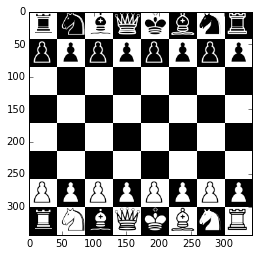

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(draw_board(im), cmap=cm.Greys_r)

In [31]:
pos = sunfish.Position(, 0, (True,True), (True,True), 0, 0)
bb = pos_board_to_bitboard(pos.board)
print bb
im = convert_bitboard_to_image(bb)
im = np.rollaxis(im, 2, 0)
print im

In [11]:
def parseFEN(fen):
	""" Parses a string in Forsyth-Edwards Notation into a Position """
	board, color, castling, enpas, hclock, fclock = fen.split()
	board = re.sub('\d', (lambda m: '.'*int(m.group(0))), board)
	board = ' '*19+'\n ' + '\n '.join(board.split('/')) + ' \n'+' '*19
	wc = ('Q' in castling, 'K' in castling)
	bc = ('k' in castling, 'q' in castling)
	ep = sunfish.parse(enpas) if enpas != '-' else 0
	score = sum(sunfish.pst[p][i] for i,p in enumerate(board) if p.isupper())
	score -= sum(sunfish.pst[p.upper()][i] for i,p in enumerate(board) if p.islower())
	pos = sunfish.Position(board, score, wc, bc, ep, 0)
	return pos if color == 'w' else pos.rotate()

In [12]:
def posboard_to_im(pos):
    bb = pos_board_to_bitboard(pos)
    im = convert_bitboard_to_image(bb)
    im = np.rollaxis(im,2,0)
    return im
def image_board(pos):
    plt.imshow(draw_board(posboard_to_im(pos)), cmap=cm.Greys_r, extent=[0.5,8.5,0.5,8.5])
    plt.show()

In [13]:
def top_bottom_moves(fen, top=5, bottom=5):
    pos = parseFEN(fen)
    bb = pos_board_to_bitboard(pos.board)
    image_board(pos.board)
    im = convert_bitboard_to_image(bb)
    im = np.rollaxis(im, 2, 0)
    print "\tCurrent evaluation: %f"%evaluator.evaluate(im)
    future_boards = []
    pos_children = []
    moves = list(pos.genMoves())
    print "Total %d moves possible"%len(moves)
    for move in moves:
        pos_child = pos.move(move).rotate()
        bb = pos_board_to_bitboard(pos_child.board)
        im = convert_bitboard_to_image(bb)
        im = np.rollaxis(im, 2, 0)
        future_boards.append(im)
        pos_children.append(pos_child.board)
    #future_boards = np.asarray(future_boards)
    values = evaluator.evaluate_batch(future_boards)
    poschildren_vals = sorted(zip(pos_children , moves, values), key=operator.itemgetter(2), reverse=True)
    print "TOP 5 Moves"
    for pos_child, move, value in poschildren_vals[0:top]:
        image_board(pos_child)
        print '\t',sunfish.render(move[0]) + sunfish.render(move[1]), value 
    print "WORST 5 Moves"
    for pos_child, move, value in poschildren_vals[-bottom:]:
        image_board(pos_child)
        print '\t',sunfish.render(move[0]) + sunfish.render(move[1]), value 

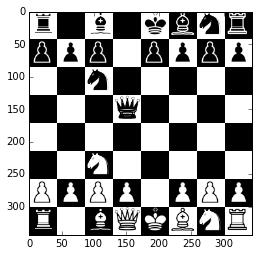

	Current evaluation: 0.008602
TOP 5 Moves


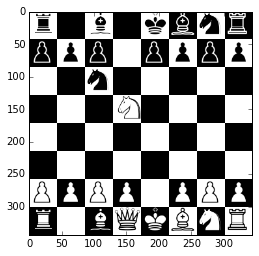

	c3d5 0.175350725651


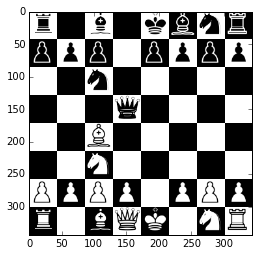

	f1c4 0.0361422710121


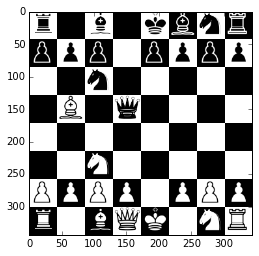

	f1b5 0.0320057831705


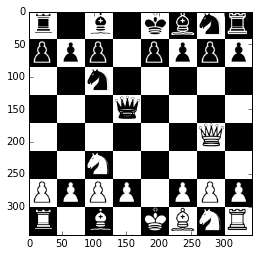

	d1g4 0.0316022820771


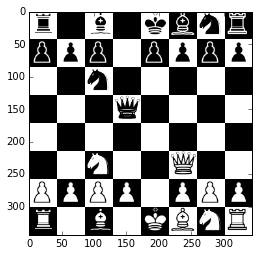

	d1f3 0.0278062429279
WORST 5 Moves


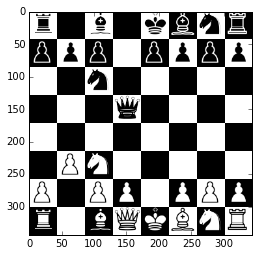

	b2b3 0.00304264388978


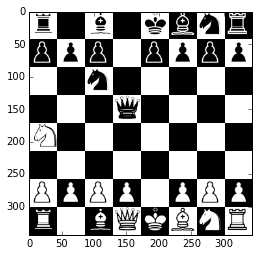

	c3a4 0.00276858406141


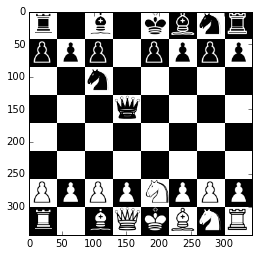

	c3e2 0.00157842657063


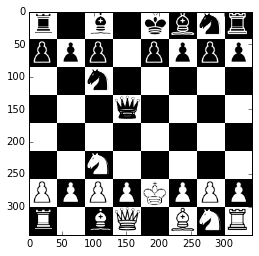

	e1e2 -0.00682969205081


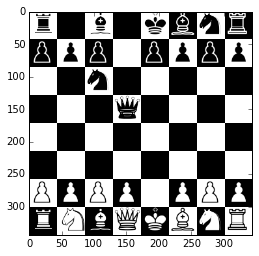

	c3b1 -0.0104185594246


In [106]:
'''
Killing Queen with a knight
'''
top_bottom_moves('r1b1kbnr/ppp1pppp/2n5/3q4/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 0 4')

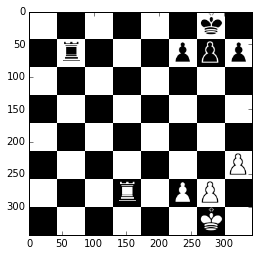

	Current evaluation: 0.069965
TOP 5 Moves


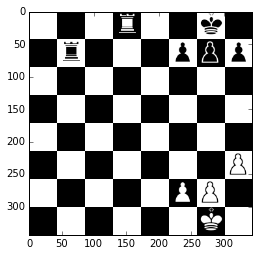

	d2d8 0.113829217851


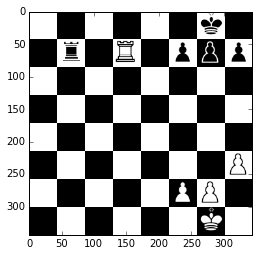

	d2d7 0.0946568623185


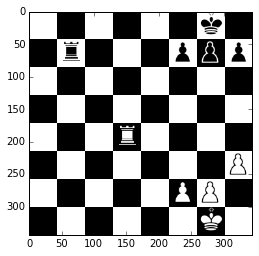

	d2d4 0.0842463597655


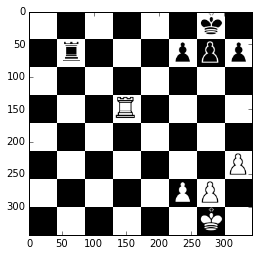

	d2d5 0.0818425565958


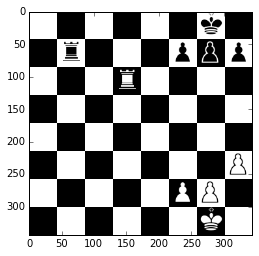

	d2d6 0.0816828161478
WORST 5 Moves


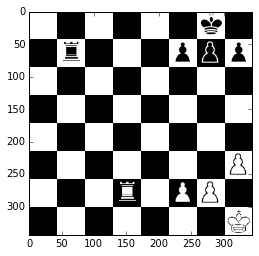

	g1h1 0.0587479807436


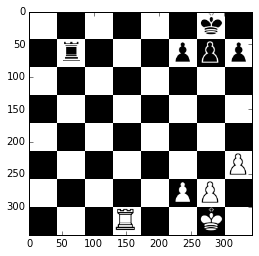

	d2d1 0.0529460534453


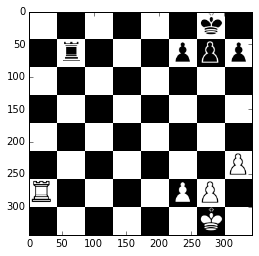

	d2a2 0.0518975481391


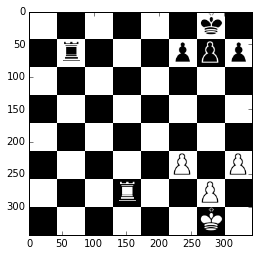

	f2f3 0.0506355985999


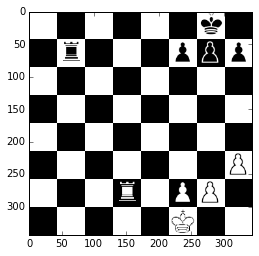

	g1f1 0.0454724282026


In [107]:
'''
Why we need to search deeper
Checkmating with a rook
'''
top_bottom_moves('6k1/1r3ppp/8/8/8/7P/3R1PP1/6K1 w - - 0 0')

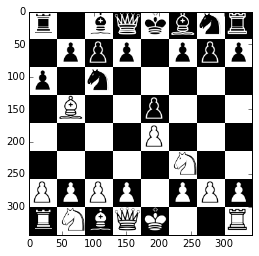

	Current evaluation: 0.026891
TOP 5 Moves


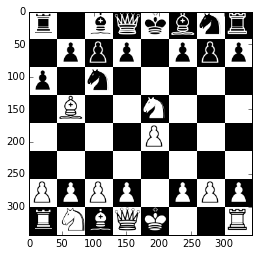

	f3e5 0.10347058624


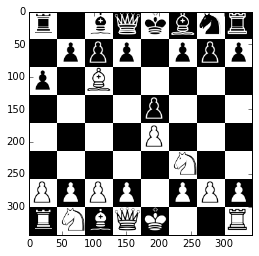

	b5c6 0.0870818346739


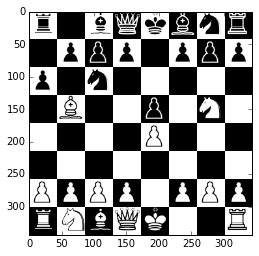

	f3g5 0.048276450485


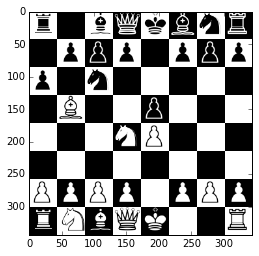

	f3d4 0.0428818836808


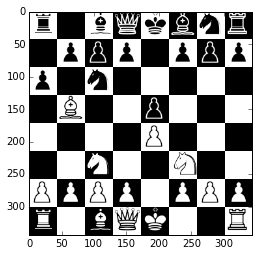

	b1c3 0.0384320765734
WORST 5 Moves


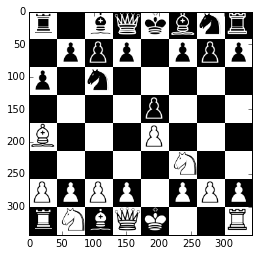

	b5a4 0.0188619177788


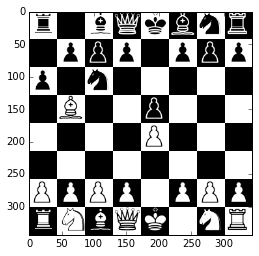

	f3g1 0.0183799359947


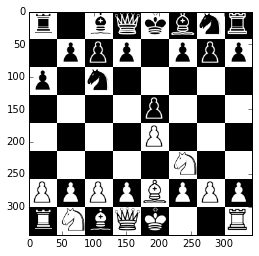

	b5e2 0.0148040046915


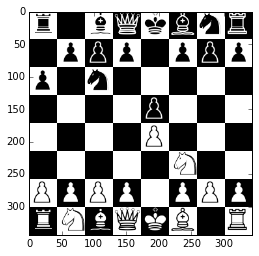

	b5f1 0.0102891717106


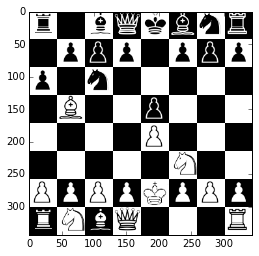

	e1e2 0.00939962919801


In [110]:
'''
Not the best move chosen
Bishop should have been traded for a knight  
'''
top_bottom_moves('r1bqkbnr/1ppp1ppp/p1n5/1B2p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 0')

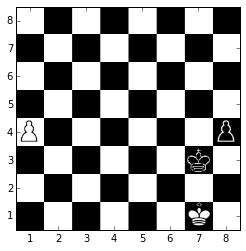

	Current evaluation: -0.002530
Total 6 moves possible
TOP 5 Moves


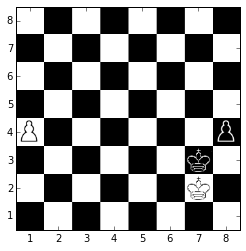

	g1g2 0.00439729122445


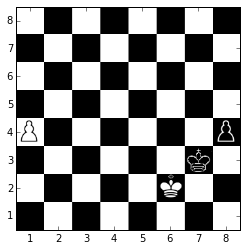

	g1f2 0.00329247233458


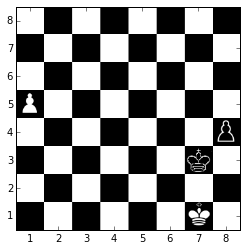

	a4a5 -0.00146991282236


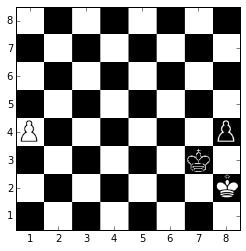

	g1h2 -0.00204685237259


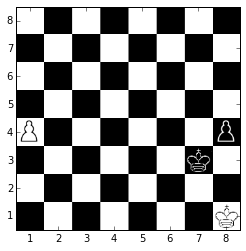

	g1h1 -0.00896658841521
WORST 5 Moves


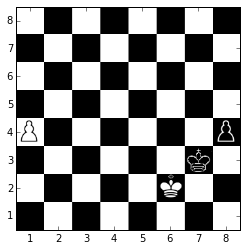

	g1f2 0.00329247233458


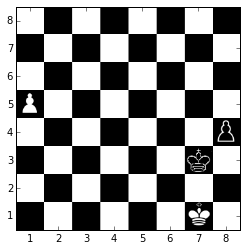

	a4a5 -0.00146991282236


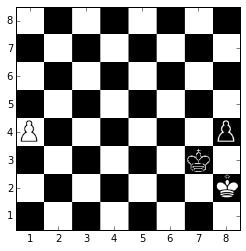

	g1h2 -0.00204685237259


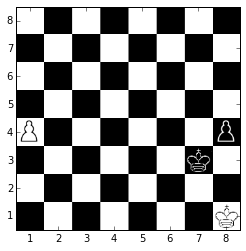

	g1h1 -0.00896658841521


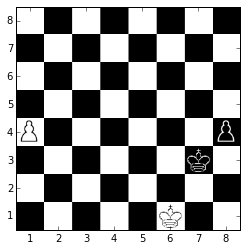

	g1f1 -0.012636997737


In [14]:
'''
Runaway Pawn
'''
top_bottom_moves('8/8/8/8/P6p/6k1/8/6K1 w - - 0 0')

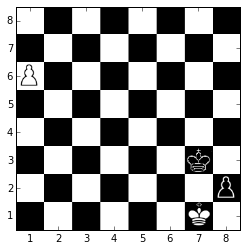

	Current evaluation: 0.069715
TOP 5 Moves


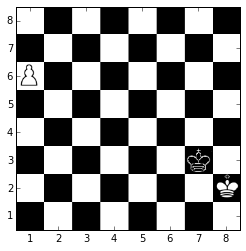

	g1h2 0.113119147718


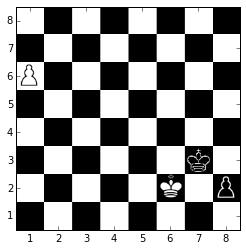

	g1f2 0.0845530852675


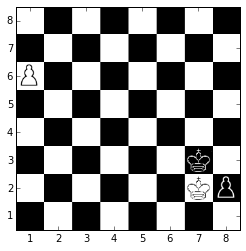

	g1g2 0.0727126449347


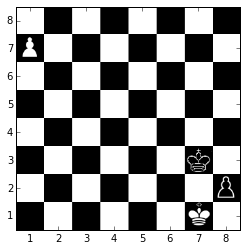

	a6a7 0.0677114725113


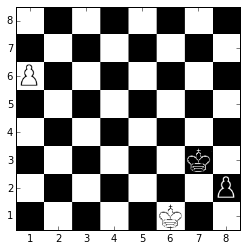

	g1f1 0.0593221075833
WORST 5 Moves


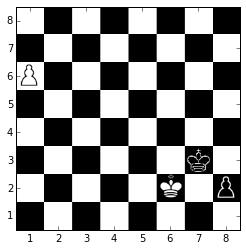

	g1f2 0.0845530852675


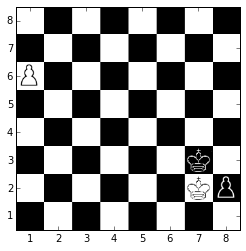

	g1g2 0.0727126449347


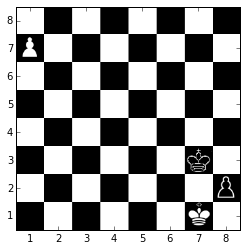

	a6a7 0.0677114725113


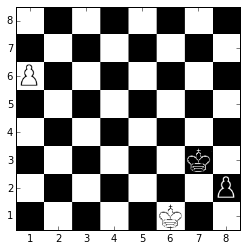

	g1f1 0.0593221075833


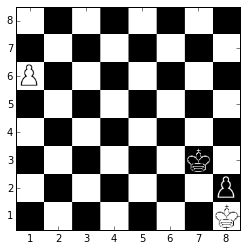

	g1h1 0.0573387891054


In [117]:
'''
Check and Blocking a promotion
'''
fen = '8/8/P7/8/8/6k1/7p/6K1 w - - 0 0'
top_bottom_moves(fen)

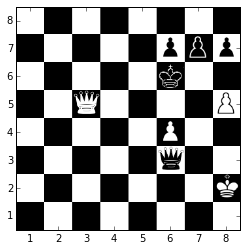

	Current evaluation: -0.041753
Total 31 moves possible
TOP 5 Moves


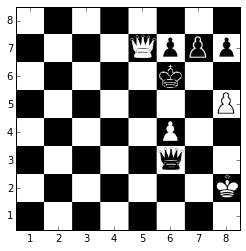

	c5e7 -0.0250520464033


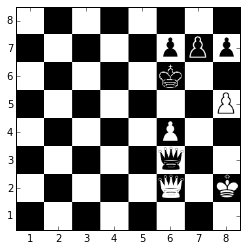

	c5f2 -0.0272542200983


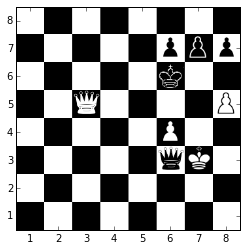

	h2g3 -0.0344499610364


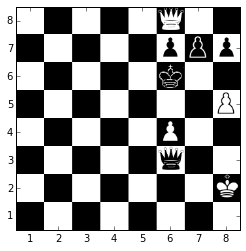

	c5f8 -0.0352950766683


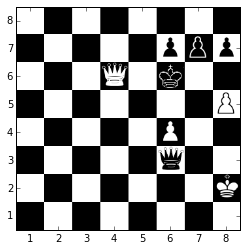

	c5d6 -0.0360224619508
WORST 5 Moves


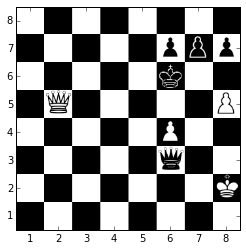

	c5b5 -0.054770257324


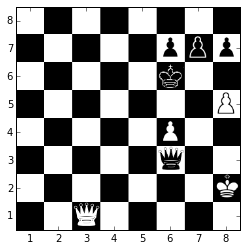

	c5c1 -0.055535748601


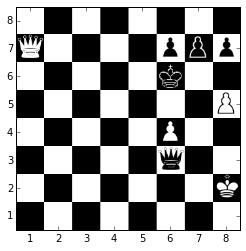

	c5a7 -0.058175727725


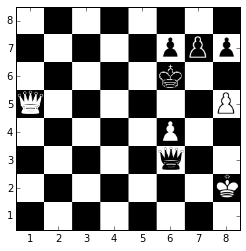

	c5a5 -0.0611421279609


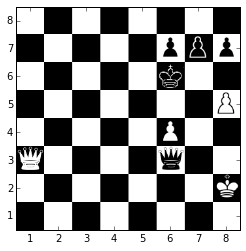

	c5a3 -0.0611713826656


In [15]:
'''
Mate in 1
'''
fen='8/5ppp/5k2/2Q4P/5P2/5q2/7K/8 w - - 0 0'
top_bottom_moves(fen)